# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

**Note:** If you are using the workspace, you will need to go to the terminal and run the command `conda update pandas` before reading in the files. This is because the version of pandas in the workspace cannot read in the transcript.json file correctly, but the newest version of pandas can. You can access the termnal from the orange icon in the top left of this notebook.  

You can see how to access the terminal and how the install works using the two images below.  First you need to access the terminal:

<img src="pic1.png"/>

Then you will want to run the above command:

<img src="pic2.png"/>

Finally, when you enter back into the notebook (use the jupyter icon again), you should be able to run the below cell without any errors.

In [1]:
import pandas as pd
import numpy as np
import math
import json
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
from IPython.display import display
import pickle

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

pd.set_option('display.max_rows', 200)
pd.set_option('display.max_columns', 200)
%matplotlib inline

In [2]:


# read in the json files
portfolio_df = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile_df = pd.read_json('data/profile.json', orient='records', lines=True)
transcript_df = pd.read_json('data/transcript.json', orient='records', lines=True)

## Portfolio Dataset

In [3]:
portfolio_df.head()

,channels,difficulty,duration,id,offer_type,reward
0,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10
1,"[web, email, mobile, social]",10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10
2,"[web, email, mobile]",0,4,3f207df678b143eea3cee63160fa8bed,informational,0
3,"[web, email, mobile]",5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5
4,"[web, email]",20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5


In [4]:
portfolio_df['offer_type'].unique()

array(['bogo', 'informational', 'discount'], dtype=object)

In [5]:
portfolio_df['channels']

0         [email, mobile, social]
1    [web, email, mobile, social]
2            [web, email, mobile]
3            [web, email, mobile]
4                    [web, email]
5    [web, email, mobile, social]
6    [web, email, mobile, social]
7         [email, mobile, social]
8    [web, email, mobile, social]
9            [web, email, mobile]
Name: channels, dtype: object

In [6]:
portfolio_df.describe()

,difficulty,duration,reward
count,10.000000,10.000000,10.000000
mean,7.700000,6.500000,4.200000
std,5.831905,2.321398,3.583915
min,0.000000,3.000000,0.000000
25%,5.000000,5.000000,2.000000
50%,8.500000,7.000000,4.000000
75%,10.000000,7.000000,5.000000
max,20.000000,10.000000,10.000000


In [7]:
cleaned_portfolio = portfolio_df.copy()
cleaned_portfolio['duration'] = cleaned_portfolio['duration'] * 24

In [8]:
# apply one hot encoding to channels column
cleaned_portfolio['web'] = cleaned_portfolio['channels'].apply(lambda x: 1 if 'web' in x else 0)
cleaned_portfolio['email'] = cleaned_portfolio['channels'].apply(lambda x: 1 if 'email' in x else 0)
cleaned_portfolio['mobile'] = cleaned_portfolio['channels'].apply(lambda x: 1 if 'mobile' in x else 0)
cleaned_portfolio['social'] = cleaned_portfolio['channels'].apply(lambda x: 1 if 'social' in x else 0)

In [9]:
# apply one hot encoding to offer_type column
offer_type = pd.get_dummies(cleaned_portfolio['offer_type'])

In [10]:
offer_type

,bogo,discount,informational
0,1,0,0
1,1,0,0
2,0,0,1
3,1,0,0
4,0,1,0
5,0,1,0
6,0,1,0
7,0,0,1
8,1,0,0
9,0,1,0


In [11]:
# drop the channels and offer_type column
cleaned_portfolio.drop(['channels', 'offer_type'], axis=1, inplace=True)

In [12]:
cleaned_portfolio = pd.concat([cleaned_portfolio, offer_type], axis=1, sort=False)

In [13]:
cleaned_portfolio

,difficulty,duration,id,reward,web,email,mobile,social,bogo,discount,informational
0,10,168,ae264e3637204a6fb9bb56bc8210ddfd,10,0,1,1,1,1,0,0
1,10,120,4d5c57ea9a6940dd891ad53e9dbe8da0,10,1,1,1,1,1,0,0
2,0,96,3f207df678b143eea3cee63160fa8bed,0,1,1,1,0,0,0,1
3,5,168,9b98b8c7a33c4b65b9aebfe6a799e6d9,5,1,1,1,0,1,0,0
4,20,240,0b1e1539f2cc45b7b9fa7c272da2e1d7,5,1,1,0,0,0,1,0
5,7,168,2298d6c36e964ae4a3e7e9706d1fb8c2,3,1,1,1,1,0,1,0
6,10,240,fafdcd668e3743c1bb461111dcafc2a4,2,1,1,1,1,0,1,0
7,0,72,5a8bc65990b245e5a138643cd4eb9837,0,0,1,1,1,0,0,1
8,5,120,f19421c1d4aa40978ebb69ca19b0e20d,5,1,1,1,1,1,0,0
9,10,168,2906b810c7d4411798c6938adc9daaa5,2,1,1,1,0,0,1,0


## Profile Dataset

In [14]:
profile_df.head()

,age,became_member_on,gender,id,income
0,118,20170212,None,68be06ca386d4c31939f3a4f0e3dd783,NaN
1,55,20170715,F,0610b486422d4921ae7d2bf64640c50b,112000.0
2,118,20180712,None,38fe809add3b4fcf9315a9694bb96ff5,NaN
3,75,20170509,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0
4,118,20170804,None,a03223e636434f42ac4c3df47e8bac43,NaN


In [15]:
profile_df['id'].nunique(), len(profile_df)

(17000, 17000)

There are 17000 profiles and 17000 records in this dataset. So Customer Profiles are unique.

In [16]:
# the number of days since the user is a memeber of starbucks
profile_df['memberdays'] = datetime.datetime.today().date() - pd.to_datetime(profile_df['became_member_on'], format='%Y%m%d').dt.date
profile_df['memberdays'] = profile_df['memberdays'].dt.days

In [17]:
# In this step, lets convert became member on field to date format
profile_df['member_from_date'] = pd.to_datetime(profile_df['became_member_on'].astype(str)).dt.date
profile_df.drop('became_member_on', 1, inplace=True)

In [18]:
profile_df.isnull().sum()

age                    0
gender              2175
id                     0
income              2175
memberdays             0
member_from_date       0
dtype: int64

Seems gender and income are null for 2175 records. Lets check those records.

In [19]:
profile_df.loc[profile_df['gender'].isnull()].describe()

,age,income,memberdays
count,2175.0,0.0,2175.000000
mean,118.0,NaN,1341.171034
std,0.0,NaN,350.201317
min,118.0,NaN,858.000000
25%,118.0,NaN,1070.000000
50%,118.0,NaN,1218.000000
75%,118.0,NaN,1609.500000
max,118.0,NaN,2677.000000


In [20]:
profile_df.loc[profile_df['gender'].isnull()].isnull().sum()

age                    0
gender              2175
id                     0
income              2175
memberdays             0
member_from_date       0
dtype: int64

So the records which has gender and income as null has 0 for income and 118 for age. So these records are not meaningful and can be dropped

In [21]:
profile_df = profile_df.loc[profile_df['gender'].isnull() == False]
profile_df.shape

(14825, 6)

In [22]:
profile_df.head()

,age,gender,id,income,memberdays,member_from_date
1,55,F,0610b486422d4921ae7d2bf64640c50b,112000.0,1234,2017-07-15
3,75,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0,1301,2017-05-09
5,68,M,e2127556f4f64592b11af22de27a7932,70000.0,949,2018-04-26
8,65,M,389bc3fa690240e798340f5a15918d5c,53000.0,1025,2018-02-09
12,58,M,2eeac8d8feae4a8cad5a6af0499a211d,51000.0,1115,2017-11-11


Text(0.5,0,'Customer Age')

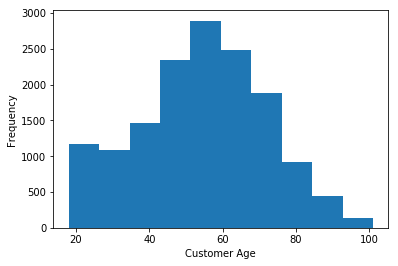

In [23]:
ax = profile_df['age'].plot(kind = 'hist')
ax.set_xlabel("Customer Age")

Text(0.5,0,'Membership days')

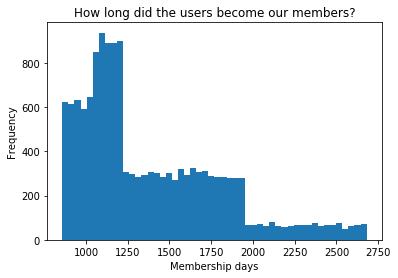

In [24]:
ax = profile_df['memberdays'].plot(kind = 'hist', bins=50, title='How long did the users become our members?')
ax.set_xlabel("Membership days")

Text(0.5,0,'Income')

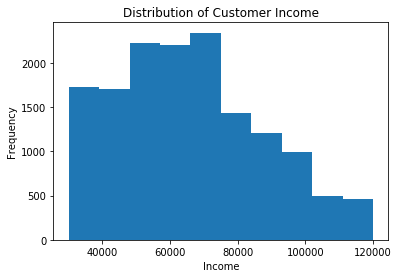

In [25]:
ax = profile_df['income'].plot(kind = 'hist', title='Distribution of Customer Income')
ax.set_xlabel("Income")

## Transcript Dataset

In [26]:
transcript_df.head()

,event,person,time,value
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'}
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}


In [27]:
transcript_df['event'].value_counts()

transaction        138953
offer received      76277
offer viewed        57725
offer completed     33579
Name: event, dtype: int64

In [28]:
# extract the rows that are related to offer action (e.g. offer received, offer viewed, offer completed)
offer = transcript_df[transcript_df['value'].apply(lambda x: True if ('offer id' in x) or ('offer_id' in x) else False)]
    
    # extract the offer id from value column
offer['offer_id'] = offer['value'].apply(lambda x: x['offer id'] if ('offer id' in x) else x['offer_id'])

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


In [29]:
offer.head()

,event,person,time,value,offer_id
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},9b98b8c7a33c4b65b9aebfe6a799e6d9
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0b1e1539f2cc45b7b9fa7c272da2e1d7
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},2906b810c7d4411798c6938adc9daaa5
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},fafdcd668e3743c1bb461111dcafc2a4
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},4d5c57ea9a6940dd891ad53e9dbe8da0


In [30]:
offer['event'].unique()

array(['offer received', 'offer viewed', 'offer completed'], dtype=object)

In [31]:
# offer has sent for these many times
offer[offer['event']=='offer received']['time'].unique()

array([  0, 168, 336, 408, 504, 576])

In [32]:
def create_user_item_matrix(offer, filename):
    '''
    Return the user item matrix that indicate the number of offer complete of a particular user
    
    INPUT:
    offer - a cleaned transcript dataframe
    filename(string) - the file name that save the user item matrix
    
    OUTPUT:
    user_item_matrix - the user item matrix which 
        - row is user 
        - column is offer
        - value is the number of offer complete by the user (NaN means no offer given)
    
    '''
    # create an empty user item matrix
    user_item_matrix = offer.groupby(['person', 'offer_id'])['event'].agg(lambda x: np.nan).unstack()
    # we just focus on bogo and discount first
    user_item_matrix.drop(list(portfolio_df[portfolio_df['offer_type']=='informational']['id']), axis=1, inplace=True)
    
    for offer_id in user_item_matrix.columns:
        print("Now processing: ", offer_id)
        num = 0
        for person in user_item_matrix.index:
            num += 1
            if num % 1000 == 0:
                print("finished ", num/16994*100, '%')
            events = []
            for event in offer[(offer['offer_id']==offer_id) & (offer['person']==person)]['event']:
                events.append(event)
            if len(events) >= 3:
                user_item_matrix.loc[person, offer_id] = 0
                for i in range(len(events)-2):
                    # check if the transaction sequence is offer received -> offer viewed -> offer completed
                    # if yes, we assume the user reacted positively with the offer we provided.
                    if (events[i] == 'offer received') & (events[i+1] == 'offer viewed') & (events[i+2] == 'offer completed'):
                        user_item_matrix.loc[person, offer_id] += 1
            elif len(events) > 0:
                user_item_matrix.loc[person, offer_id] = 0
    
    # store the large martix into file
    fh = open(filename, 'wb')
    pickle.dump(user_item_matrix,fh)
    fh.close()
    
    return user_item_matrix

In [33]:
train_size = int(offer.shape[0]*0.7)
test_size = offer.shape[0] - train_size
train_size, test_size

(117306, 50275)

In [34]:
#It takes more than 20 minutes to run this part of code. 
#So i have stored output as seperate file. And will load the data file in next line.
#full_df = create_user_item_matrix(offer, 'user_item_matrix.p')

In [35]:
train_offer = offer[:train_size]

In [36]:
test_offer = offer[train_size:]

In [37]:
#It takes more than 20 minutes to run this part of code. 
#So i have stored output as seperate file. And will load the data file in next line.
#test_df = create_user_item_matrix(test_offer, 'test_df.p')

In [38]:
#It takes more than 20 minutes to run this part of code. 
#So i have stored output as seperate file. And will load the data file in next line.
#train_df = create_user_item_matrix(train_offer, 'train_df.p')

In [39]:
# Read full user item matrix to full dataframe
full_df = pd.read_pickle('user_item_matrix.p')

In [40]:
# Load the train data user item matrix to train data frame
train_df = pd.read_pickle('train_df.p')

In [41]:
# Load the test user item matrix to test data frame
test_df = pd.read_pickle('train_df.p')

In [42]:
full_df.head()

offer_id,0b1e1539f2cc45b7b9fa7c272da2e1d7,2298d6c36e964ae4a3e7e9706d1fb8c2,2906b810c7d4411798c6938adc9daaa5,4d5c57ea9a6940dd891ad53e9dbe8da0,9b98b8c7a33c4b65b9aebfe6a799e6d9,ae264e3637204a6fb9bb56bc8210ddfd,f19421c1d4aa40978ebb69ca19b0e20d,fafdcd668e3743c1bb461111dcafc2a4
person,,,,,,,,
0009655768c64bdeb2e877511632db8f,NaN,NaN,0.0,NaN,NaN,NaN,0.0,0.0
00116118485d4dfda04fdbaba9a87b5c,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN
0011e0d4e6b944f998e987f904e8c1e5,1.0,1.0,NaN,NaN,1.0,NaN,NaN,NaN
0020c2b971eb4e9188eac86d93036a77,NaN,NaN,NaN,1.0,NaN,0.0,NaN,1.0
0020ccbbb6d84e358d3414a3ff76cffd,NaN,1.0,NaN,NaN,1.0,NaN,1.0,NaN


In [43]:
train_df.head()

offer_id,0b1e1539f2cc45b7b9fa7c272da2e1d7,2298d6c36e964ae4a3e7e9706d1fb8c2,2906b810c7d4411798c6938adc9daaa5,4d5c57ea9a6940dd891ad53e9dbe8da0,9b98b8c7a33c4b65b9aebfe6a799e6d9,ae264e3637204a6fb9bb56bc8210ddfd,f19421c1d4aa40978ebb69ca19b0e20d,fafdcd668e3743c1bb461111dcafc2a4
person,,,,,,,,
0009655768c64bdeb2e877511632db8f,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0
00116118485d4dfda04fdbaba9a87b5c,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN
0011e0d4e6b944f998e987f904e8c1e5,0.0,1.0,NaN,NaN,0.0,NaN,NaN,NaN
0020c2b971eb4e9188eac86d93036a77,NaN,NaN,NaN,0.0,NaN,0.0,NaN,1.0
0020ccbbb6d84e358d3414a3ff76cffd,NaN,1.0,NaN,NaN,0.0,NaN,1.0,NaN


In [44]:
test_df.head()

offer_id,0b1e1539f2cc45b7b9fa7c272da2e1d7,2298d6c36e964ae4a3e7e9706d1fb8c2,2906b810c7d4411798c6938adc9daaa5,4d5c57ea9a6940dd891ad53e9dbe8da0,9b98b8c7a33c4b65b9aebfe6a799e6d9,ae264e3637204a6fb9bb56bc8210ddfd,f19421c1d4aa40978ebb69ca19b0e20d,fafdcd668e3743c1bb461111dcafc2a4
person,,,,,,,,
0009655768c64bdeb2e877511632db8f,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0
00116118485d4dfda04fdbaba9a87b5c,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN
0011e0d4e6b944f998e987f904e8c1e5,0.0,1.0,NaN,NaN,0.0,NaN,NaN,NaN
0020c2b971eb4e9188eac86d93036a77,NaN,NaN,NaN,0.0,NaN,0.0,NaN,1.0
0020ccbbb6d84e358d3414a3ff76cffd,NaN,1.0,NaN,NaN,0.0,NaN,1.0,NaN


In [45]:
def FunkSVD(complete_matrix, latent_features=12, learning_rate=0.0001, iters=100):
    '''
    This function performs matrix factorization using a basic form of FunkSVD with no regularization
    
    INPUT:
    complete_mat - (numpy array) a matrix with users as rows, offers as columns, and offer completed as values
    latent_features - (int) the number of latent features used
    learning_rate - (float) the learning rate 
    iters - (int) the number of iterations
    
    OUTPUT:
    user_mat - (numpy array) a user by latent feature matrix
    offer_mat - (numpy array) a latent feature by offer matrix
    '''
    
    # Set up useful values to be used through the rest of the function
    n_users = complete_matrix.shape[0]
    n_offers = complete_matrix.shape[1]
    num_complete = np.count_nonzero(~np.isnan(complete_matrix))
    
    # initialize the user and movie matrices with random values
    user_matrix = np.random.rand(n_users, latent_features)
    offer_matrix = np.random.rand(latent_features, n_offers)
    
    # initialize sse at 0 for first iteration
    sse_accum = 0
    
    # keep track of iteration and MSE
    print("Optimizaiton Statistics")
    print("Iterations | Mean Squared Error ")
    
    # for each iteration
    for iteration in range(iters):

        # update our sse
        old_sse = sse_accum
        sse_accum = 0
        
        # For each user-offer pair
        for i in range(n_users):
            for j in range(n_offers):
                
                # if the rating exists
                if complete_matrix[i, j] >= 0:
                    
                    # compute the error as the actual minus the dot product of the user and offer latent features
                    diff = complete_matrix[i, j] - np.dot(user_matrix[i, :], offer_matrix[:, j])
                    
                    # Keep track of the sum of squared errors for the matrix
                    sse_accum += diff**2
                    
                    # update the values in each matrix in the direction of the gradient
                    for k in range(latent_features):
                        user_matrix[i, k] += learning_rate * (2*diff*offer_matrix[k, j])
                        offer_matrix[k, j] += learning_rate * (2*diff*user_matrix[i, k])

        # print results
        print("%d \t\t %f" % (iteration+1, sse_accum / num_complete))
        
    return user_matrix, offer_matrix

In [46]:
# Create user-by-item matrix - nothing to do here
train_data_np = np.array(train_df)

# Fit FunkSVD with the specified hyper parameters to the training data
user_matrix, offer_matrix = FunkSVD(train_data_np, latent_features=15, learning_rate=0.005, iters=250)

Optimizaiton Statistics
Iterations | Mean Squared Error 
1 		 0.312675
2 		 0.267030
3 		 0.266673
4 		 0.266295
5 		 0.265910
6 		 0.265519
7 		 0.265122
8 		 0.264718
9 		 0.264307
10 		 0.263888
11 		 0.263460
12 		 0.263023
13 		 0.262576
14 		 0.262119
15 		 0.261650
16 		 0.261169
17 		 0.260675
18 		 0.260168
19 		 0.259645
20 		 0.259107
21 		 0.258551
22 		 0.257978
23 		 0.257384
24 		 0.256770
25 		 0.256134
26 		 0.255474
27 		 0.254788
28 		 0.254076
29 		 0.253335
30 		 0.252563
31 		 0.251758
32 		 0.250919
33 		 0.250043
34 		 0.249129
35 		 0.248173
36 		 0.247173
37 		 0.246128
38 		 0.245034
39 		 0.243889
40 		 0.242690
41 		 0.241435
42 		 0.240121
43 		 0.238746
44 		 0.237307
45 		 0.235801
46 		 0.234226
47 		 0.232580
48 		 0.230860
49 		 0.229064
50 		 0.227190
51 		 0.225237
52 		 0.223204
53 		 0.221088
54 		 0.218889
55 		 0.216608
56 		 0.214243
57 		 0.211794
58 		 0.209264
59 		 0.206652
60 		 0.203961
61 		 0.201192
62 		 0.198348
63 		 0.195432
64 		 0

In [47]:
# Try with latent features 10
user_matrix_10, offer_matrix_10 = FunkSVD(train_data_np, latent_features=10, learning_rate=0.005, iters=250)

Optimizaiton Statistics
Iterations | Mean Squared Error 
1 		 0.292336
2 		 0.266724
3 		 0.266260
4 		 0.265790
5 		 0.265318
6 		 0.264843
7 		 0.264366
8 		 0.263885
9 		 0.263402
10 		 0.262915
11 		 0.262425
12 		 0.261931
13 		 0.261432
14 		 0.260930
15 		 0.260423
16 		 0.259910
17 		 0.259392
18 		 0.258869
19 		 0.258339
20 		 0.257802
21 		 0.257258
22 		 0.256707
23 		 0.256147
24 		 0.255579
25 		 0.255000
26 		 0.254412
27 		 0.253813
28 		 0.253202
29 		 0.252579
30 		 0.251943
31 		 0.251292
32 		 0.250626
33 		 0.249945
34 		 0.249246
35 		 0.248528
36 		 0.247791
37 		 0.247034
38 		 0.246254
39 		 0.245452
40 		 0.244624
41 		 0.243770
42 		 0.242888
43 		 0.241977
44 		 0.241035
45 		 0.240060
46 		 0.239050
47 		 0.238004
48 		 0.236920
49 		 0.235796
50 		 0.234630
51 		 0.233420
52 		 0.232164
53 		 0.230861
54 		 0.229508
55 		 0.228103
56 		 0.226645
57 		 0.225133
58 		 0.223563
59 		 0.221936
60 		 0.220249
61 		 0.218501
62 		 0.216692
63 		 0.214819
64 		 0

In [48]:
# Try with latent features 5
user_matrix_5, offer_matrix_5 = FunkSVD(train_data_np, latent_features=5, learning_rate=0.005, iters=250)

Optimizaiton Statistics
Iterations | Mean Squared Error 
1 		 0.281762
2 		 0.268257
3 		 0.267429
4 		 0.266598
5 		 0.265766
6 		 0.264933
7 		 0.264099
8 		 0.263265
9 		 0.262430
10 		 0.261594
11 		 0.260757
12 		 0.259920
13 		 0.259082
14 		 0.258243
15 		 0.257403
16 		 0.256562
17 		 0.255720
18 		 0.254877
19 		 0.254032
20 		 0.253186
21 		 0.252339
22 		 0.251490
23 		 0.250640
24 		 0.249787
25 		 0.248933
26 		 0.248076
27 		 0.247218
28 		 0.246356
29 		 0.245492
30 		 0.244626
31 		 0.243756
32 		 0.242883
33 		 0.242006
34 		 0.241125
35 		 0.240240
36 		 0.239351
37 		 0.238457
38 		 0.237558
39 		 0.236654
40 		 0.235744
41 		 0.234828
42 		 0.233905
43 		 0.232975
44 		 0.232038
45 		 0.231093
46 		 0.230140
47 		 0.229178
48 		 0.228207
49 		 0.227226
50 		 0.226235
51 		 0.225233
52 		 0.224219
53 		 0.223194
54 		 0.222156
55 		 0.221105
56 		 0.220040
57 		 0.218961
58 		 0.217866
59 		 0.216756
60 		 0.215630
61 		 0.214487
62 		 0.213326
63 		 0.212147
64 		 0

In [49]:
def predict_reaction(user_matrix, offer_matrix, user_id, offer_id):
    '''
    We can use this to make predictions for how users would react with the offers
    
    INPUT:
    user_matrix - user by latent factor matrix
    offer_matrix - latent factor by offer matrix
    user_id - the user_id from the reviews df
    offer_id - the offer_id according the offers df
    
    OUTPUT:
    pred - the predicted reaction for user_id-offer_id according to FunkSVD
    '''
    try:
        # Use the training data to create a series of users and movies that matches the ordering in training data
        user_ids_series = np.array(train_df.index)
        offer_ids_series = np.array(train_df.columns)

        # User row and Movie Column
        user_row = np.where(user_ids_series == user_id)[0][0]
        offer_col = np.where(offer_ids_series == offer_id)[0][0]

        # Take dot product of that row and column in U and V to make prediction
        pred = np.dot(user_matrix[user_row, :], offer_matrix[:, offer_col])
        
        return pred
    
    except:
        #print("I'm sorry, but a prediction cannot be made for this user-offer pair.  It looks like one of these items does not exist in our current database.")
    
        return None

In [50]:
def validation(test_df, user_mat, offer_mat):
    '''Measure the squared errors for the prediction'''
    num_complete = np.count_nonzero(~np.isnan(test_df))
    
    sse_accum = 0
    
    for user_id in test_df.index:
        for offer_id in test_df.columns:
            if ~np.isnan(test_df.loc[user_id, offer_id]):
                predict_value = predict_reaction(user_mat, offer_mat, user_id, offer_id)
                if predict_value != None:
                    # compute the error as the actual minus the dot product of the user and offer latent features
                    diff = test_df.loc[user_id, offer_id] - predict_reaction(user_mat, offer_mat, user_id, offer_id)

                    # Keep track of the sum of squared errors for the matrix
                    sse_accum += diff**2
    
    print(sse_accum / num_complete)

In [51]:
# Evaluation for latent features of 15
validation(test_df, user_matrix, offer_matrix)

0.00683820526811


In [52]:
# Evaluation for latent features of 10
validation(test_df, user_matrix_10, offer_matrix_10)

0.00741570550087


In [53]:
# Evaluation for latent features of 5
validation(test_df, user_matrix_5, offer_matrix_5)

0.0220243697221


In [57]:
def best_sale_offer(user_item_matrix):
    # Find out which offer sells the best

    offer_gain = []
    for offer_id in user_item_matrix.columns:
        offer_gain.append([offer_id, transcript_df[(transcript_df['person'].isin(list(user_item_matrix[user_item_matrix[offer_id]>=1].index)))&(transcript_df['event']=='transaction')]['value'].apply(lambda x: x['amount']).sum()])

    offer_value = pd.DataFrame(offer_gain, columns=['offer_id', 'gain'])
    offer_value['gain'] = pd.to_numeric(offer_value['gain'])
    offer_value.sort_values(by='gain', ascending=False, inplace=True)
    print(offer_value)
    
    best_sale = offer_value.plot(kind='bar', title='Sale Amount of Different Offers')
    best_sale.set_xlabel('Offer number')
    best_sale.set_ylabel('Sale Amount')
    
    return offer_value

In [75]:
def recommend_offer(user_id, user_mat, offer_mat):
    recommend = {}
    for offer_id in train_df.columns:
        pred_val = predict_reaction(user_mat, offer_mat, user_id, offer_id)
        if pred_val != None:
            recommend[offer_id] = pred_val
        else:
            break
    if pred_val == None:
        print("Selected user is not available in the database, So we are giving back the best sale offer recommendations amongst all users.")
        top_offer = best_sale_offer(full_df)
        for offer_id in top_offer['offer_id']:
            print("offer id: ", offer_id)
    else:
        print("recommend offer for user ", user_id)
        for offer_id, pred_val in sorted(recommend.items(), key=lambda kv:(kv[1], kv[0]), reverse=True):
            print("offer id: ", offer_id, " predicted value: ", round(pred_val,2))

In [63]:
cleaned_portfolio.head(10)

,difficulty,duration,id,reward,web,email,mobile,social,bogo,discount,informational
0,10,168,ae264e3637204a6fb9bb56bc8210ddfd,10,0,1,1,1,1,0,0
1,10,120,4d5c57ea9a6940dd891ad53e9dbe8da0,10,1,1,1,1,1,0,0
2,0,96,3f207df678b143eea3cee63160fa8bed,0,1,1,1,0,0,0,1
3,5,168,9b98b8c7a33c4b65b9aebfe6a799e6d9,5,1,1,1,0,1,0,0
4,20,240,0b1e1539f2cc45b7b9fa7c272da2e1d7,5,1,1,0,0,0,1,0
5,7,168,2298d6c36e964ae4a3e7e9706d1fb8c2,3,1,1,1,1,0,1,0
6,10,240,fafdcd668e3743c1bb461111dcafc2a4,2,1,1,1,1,0,1,0
7,0,72,5a8bc65990b245e5a138643cd4eb9837,0,0,1,1,1,0,0,1
8,5,120,f19421c1d4aa40978ebb69ca19b0e20d,5,1,1,1,1,1,0,0
9,10,168,2906b810c7d4411798c6938adc9daaa5,2,1,1,1,0,0,1,0


In [71]:
# Let us pick few users from the train data set to test the prediction model
train_df.head()

offer_id,0b1e1539f2cc45b7b9fa7c272da2e1d7,2298d6c36e964ae4a3e7e9706d1fb8c2,2906b810c7d4411798c6938adc9daaa5,4d5c57ea9a6940dd891ad53e9dbe8da0,9b98b8c7a33c4b65b9aebfe6a799e6d9,ae264e3637204a6fb9bb56bc8210ddfd,f19421c1d4aa40978ebb69ca19b0e20d,fafdcd668e3743c1bb461111dcafc2a4
person,,,,,,,,
0009655768c64bdeb2e877511632db8f,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0
00116118485d4dfda04fdbaba9a87b5c,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN
0011e0d4e6b944f998e987f904e8c1e5,0.0,1.0,NaN,NaN,0.0,NaN,NaN,NaN
0020c2b971eb4e9188eac86d93036a77,NaN,NaN,NaN,0.0,NaN,0.0,NaN,1.0
0020ccbbb6d84e358d3414a3ff76cffd,NaN,1.0,NaN,NaN,0.0,NaN,1.0,NaN


In [68]:
#1 recommend offer for a particular user
recommend_offer('78afa995795e4d85b5d9ceeca43f5fef', user_matrix, offer_matrix)

recommend offer for user  78afa995795e4d85b5d9ceeca43f5fef
offer id:  fafdcd668e3743c1bb461111dcafc2a4  predicted value:  1.26
offer id:  9b98b8c7a33c4b65b9aebfe6a799e6d9  predicted value:  1.09
offer id:  ae264e3637204a6fb9bb56bc8210ddfd  predicted value:  0.1
offer id:  f19421c1d4aa40978ebb69ca19b0e20d  predicted value:  0.09
offer id:  0b1e1539f2cc45b7b9fa7c272da2e1d7  predicted value:  -0.25
offer id:  2298d6c36e964ae4a3e7e9706d1fb8c2  predicted value:  -0.26
offer id:  2906b810c7d4411798c6938adc9daaa5  predicted value:  -0.49
offer id:  4d5c57ea9a6940dd891ad53e9dbe8da0  predicted value:  -0.82


In [72]:
#2 recommend offer for a particular user
recommend_offer('0020c2b971eb4e9188eac86d93036a77', user_matrix, offer_matrix)

recommend offer for user  0020c2b971eb4e9188eac86d93036a77
offer id:  fafdcd668e3743c1bb461111dcafc2a4  predicted value:  1.01
offer id:  9b98b8c7a33c4b65b9aebfe6a799e6d9  predicted value:  0.5
offer id:  2298d6c36e964ae4a3e7e9706d1fb8c2  predicted value:  0.39
offer id:  f19421c1d4aa40978ebb69ca19b0e20d  predicted value:  0.18
offer id:  0b1e1539f2cc45b7b9fa7c272da2e1d7  predicted value:  0.05
offer id:  2906b810c7d4411798c6938adc9daaa5  predicted value:  0.02
offer id:  4d5c57ea9a6940dd891ad53e9dbe8da0  predicted value:  0.0
offer id:  ae264e3637204a6fb9bb56bc8210ddfd  predicted value:  -0.0


Selected user is not available in the database, So we are giving back the best sale offer recommendations amongst all users.
                           offer_id       gain
7  fafdcd668e3743c1bb461111dcafc2a4  596220.84
1  2298d6c36e964ae4a3e7e9706d1fb8c2  538027.98
6  f19421c1d4aa40978ebb69ca19b0e20d  480555.03
3  4d5c57ea9a6940dd891ad53e9dbe8da0  441918.93
5  ae264e3637204a6fb9bb56bc8210ddfd  423683.27
2  2906b810c7d4411798c6938adc9daaa5  305568.42
4  9b98b8c7a33c4b65b9aebfe6a799e6d9  304361.77
0  0b1e1539f2cc45b7b9fa7c272da2e1d7  218905.94
offer id:  fafdcd668e3743c1bb461111dcafc2a4
offer id:  2298d6c36e964ae4a3e7e9706d1fb8c2
offer id:  f19421c1d4aa40978ebb69ca19b0e20d
offer id:  4d5c57ea9a6940dd891ad53e9dbe8da0
offer id:  ae264e3637204a6fb9bb56bc8210ddfd
offer id:  2906b810c7d4411798c6938adc9daaa5
offer id:  9b98b8c7a33c4b65b9aebfe6a799e6d9
offer id:  0b1e1539f2cc45b7b9fa7c272da2e1d7


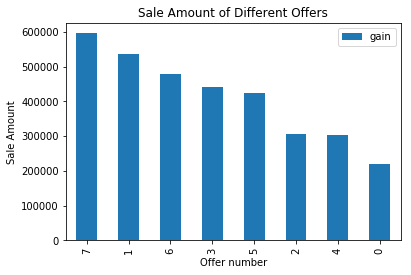

In [76]:
# we recommend top best sale offer to a new user
recommend_offer('newuser', user_matrix, offer_matrix)